In [1]:
#Import datasets
import pandas as pd 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

#grafting/ acrage table
graft_df = pd.read_csv("graft.csv")

#production table
prod_df = pd.read_csv("production.csv")


In [2]:
#merge graft and production datasets 
df = prod_df.merge(graft_df)

#Make prod_wk datetime
df['prod_wk'] = pd.to_datetime(df['prod_wk'])

#Remove unneeded columns 
df = df.drop(['prod_date_cnt', 'prod_wk_no', 'min_date','max_date' ], axis=1)

In [3]:
#data cleaning
boxes = df['var_boxes']
acres = df['acres']

one_hot = pd.get_dummies(df['variety_desc'])

# Concatenate the one-hot encoded column with the original dataframe
df = pd.concat([df, one_hot], axis=1)

#create a new column for production yield (boxes per acre)
df['yield'] = boxes/acres 

#create a new column for age of the variety 
prod_yr = df['prod_yr'] 
graft_year = df['year_planted_grafted'] 
df['age'] = prod_yr - graft_year

#create a new column for yield classification: 
# High(2) : yield > 170  | Medium(1) : 170 > yield > 55   | Low(0) : yield < 55 
df['yield_class'] = df['yield'].apply(lambda x: 'high' if x > 175 else ('medium' if x >= 55  else 'low'))

df

,prod_wk,ranch_no,ranch_sub,var_cd,variety_desc,var_boxes,color,prod_yr,grafted,acres,...,IVORY - SHEEGENE 21,RED GLOBE,SCARLET ROYAL,SUGRAONE,SWEET GLOBE,SWEET SCARLET,THOMPSON SEEDLESS,yield,age,yield_class
0,2015-07-13,1,NaN,178,ARRA 15 - SWEETIES,3905,GREEN,2015,True,36.00,...,0,0,0,0,0,0,0,108.472222,6,medium
1,2015-07-20,1,NaN,178,ARRA 15 - SWEETIES,1075,GREEN,2015,True,36.00,...,0,0,0,0,0,0,0,29.861111,6,low
2,2015-07-27,1,NaN,178,ARRA 15 - SWEETIES,2047,GREEN,2015,True,36.00,...,0,0,0,0,0,0,0,56.861111,6,medium
3,2015-08-03,1,NaN,178,ARRA 15 - SWEETIES,6121,GREEN,2015,True,36.00,...,0,0,0,0,0,0,0,170.027778,6,medium
4,2015-08-10,1,NaN,178,ARRA 15 - SWEETIES,724,GREEN,2015,True,36.00,...,0,0,0,0,0,0,0,20.111111,6,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,2022-08-15,50,NaN,307,IVORY - SHEEGENE 21,2189,GREEN,2022,False,27.70,...,1,0,0,0,0,0,0,79.025271,4,medium
4267,2022-08-15,50,NaN,307,IVORY - SHEEGENE 21,2189,GREEN,2022,False,24.50,...,1,0,0,0,0,0,0,89.346939,3,medium
4268,2022-08-15,50,NaN,307,IVORY - SHEEGENE 21,2189,GREEN,2022,True,18.92,...,1,0,0,0,0,0,0,115.697674,3,medium
4269,2022-08-15,50,NaN,307,IVORY - SHEEGENE 21,2189,GREEN,2022,True,114.36,...,1,0,0,0,0,0,0,19.141308,2,low


In [4]:
num_high_yield = (df['yield_class'] == 'high').sum()
print(f"There are {num_high_yield} high yield values.")

num_med_yield = (df['yield_class'] == 'medium').sum()
print(f"There are {num_med_yield} medium yield values.")

num_low_yield = (df['yield_class'] == 'low').sum()
print(f"There are {num_low_yield} low yield values.")

There are 1232 high yield values.
There are 1660 medium yield values.
There are 1379 low yield values.


In [5]:
#rename
df = df.rename(columns={'prod_wk': 'date'})
# Extract datetime features
#Split the Date column into three columns (year, month, date) and then drop it from the dataset
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop('date', axis=1)
df.head()

,ranch_no,ranch_sub,var_cd,variety_desc,var_boxes,color,prod_yr,grafted,acres,year_planted_grafted,...,SUGRAONE,SWEET GLOBE,SWEET SCARLET,THOMPSON SEEDLESS,yield,age,yield_class,year,month,day
0,1,NaN,178,ARRA 15 - SWEETIES,3905,GREEN,2015,True,36.0,2009,...,0,0,0,0,108.472222,6,medium,2015,7,13
1,1,NaN,178,ARRA 15 - SWEETIES,1075,GREEN,2015,True,36.0,2009,...,0,0,0,0,29.861111,6,low,2015,7,20
2,1,NaN,178,ARRA 15 - SWEETIES,2047,GREEN,2015,True,36.0,2009,...,0,0,0,0,56.861111,6,medium,2015,7,27
3,1,NaN,178,ARRA 15 - SWEETIES,6121,GREEN,2015,True,36.0,2009,...,0,0,0,0,170.027778,6,medium,2015,8,3
4,1,NaN,178,ARRA 15 - SWEETIES,724,GREEN,2015,True,36.0,2009,...,0,0,0,0,20.111111,6,low,2015,8,10


In [6]:
#one hot encode the color and ranch_no column  
df['color_code'] = pd.factorize(df['color'])[0]
one_hot = pd.get_dummies(df['color'], prefix='color')
df = pd.concat([df, one_hot], axis=1)

one_hot2 = pd.get_dummies(df['ranch_no'], prefix = 'ranch')
df = pd.concat([df, one_hot2], axis=1)



In [7]:
#import weather and precipitation dataset
temps_df = pd.read_csv("temps.csv")

#drop unneeded columns 
temps_df = temps_df.drop(['Unnamed: 4', 'Unnamed: 5'], axis=1)

# convert the 'Date' column to datetime format
temps_df['Date'] = pd.to_datetime(temps_df['Date'])

# set the 'Date' column as the index
temps_df.set_index('Date', inplace=True)

# resample the data by week and calculate the mean of 'Daily_High'
weekly_avg = temps_df['Daily_High'].resample('W').mean()

#Make weekly_avg into a dataframe
weekly_avg = pd.DataFrame(weekly_avg)

#Add weekly_low_avg to weekly_avg
weekly_avg['weekly_low_avg'] =  temps_df['Daily _Low'].resample('W').mean()
#Add weekly_precipitation_avg to weekly_avg
weekly_avg['weekly_precipitation_avg'] =  temps_df['Precipitation '].resample('W').mean()
#Rename 'Daily_High' to 'weekly_high_avg'
weekly_avg = weekly_avg.rename(columns={'Daily_High': 'weekly_high_avg'})

temps_df.head()

,Daily_High,Daily _Low,Precipitation
Date,,,
2015-01-01,54,28,0.0
2015-01-02,54,30,0.0
2015-01-03,55,31,0.0
2015-01-04,58,31,0.0
2015-01-05,59,33,0.0


In [8]:
#split the Date column into three columns (year, month, date) and then drop it from the dataset
temps_df.reset_index(inplace=True) 
temps_df['year'] = temps_df['Date'].dt.year
temps_df['month'] = temps_df['Date'].dt.month
temps_df['day'] = temps_df['Date'].dt.day
temps_df = temps_df.drop(['Date'], axis=1)
temps_df

,Daily_High,Daily _Low,Precipitation,year,month,day
0,54,28,0.00,2015,1,1
1,54,30,0.00,2015,1,2
2,55,31,0.00,2015,1,3
3,58,31,0.00,2015,1,4
4,59,33,0.00,2015,1,5
...,...,...,...,...,...,...
2904,56,43,0.83,2022,12,27
2905,58,47,0.02,2022,12,28
2906,55,47,0.03,2022,12,29
2907,66,51,0.00,2022,12,30


In [9]:
#A fully merged dataset
merged_df = pd.merge(df, temps_df, on=['year', 'month', 'day'], how='inner')
merged_df

,ranch_no,ranch_sub,var_cd,variety_desc,var_boxes,color,prod_yr,grafted,acres,year_planted_grafted,...,ranch_32,ranch_33,ranch_34,ranch_35,ranch_36,ranch_37,ranch_50,Daily_High,Daily _Low,Precipitation
0,1,NaN,178,ARRA 15 - SWEETIES,3905,GREEN,2015,True,36.00,2009,...,0,0,0,0,0,0,0,94,68,0.0
1,14,NaN,16,ARRA 16,3038,GREEN,2015,True,8.00,2017,...,0,0,0,0,0,0,0,94,68,0.0
2,14,NaN,16,ARRA 16,3038,GREEN,2015,True,10.00,2018,...,0,0,0,0,0,0,0,94,68,0.0
3,29,SW,71,SUGRAONE,6389,GREEN,2015,True,18.00,2006,...,0,0,0,0,0,0,0,94,68,0.0
4,29,NW,71,SUGRAONE,23119,GREEN,2015,True,70.00,2006,...,0,0,0,0,0,0,0,94,68,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,32,NE,96,AUTUMN KING,23204,GREEN,2018,False,282.80,2012,...,1,0,0,0,0,0,0,74,39,0.0
4263,32,NW,755,ARRA 28 - ARRA PASSION PUNCH,667,RED,2018,True,69.35,2017,...,1,0,0,0,0,0,0,74,39,0.0
4264,33,W,90,EARLY SWEET,4155,GREEN,2019,False,63.00,2009,...,0,1,0,0,0,0,0,93,65,0.0
4265,33,W,90,EARLY SWEET,4155,GREEN,2019,True,35.00,2017,...,0,1,0,0,0,0,0,93,65,0.0


In [10]:
#Drop unneccessary columns and rows with NAN and infinity values
#This set has both var_boxes and acres

df2 = df.drop(['ranch_sub', 'prod_yr', 'color', 'yield', 'color_code','variety_desc', 'ranch_no', 'var_cd'], axis=1)
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()

#merge weather dataset so production/graft datasets
merged_df = pd.merge(df2, temps_df, on=['year', 'month', 'day'], how='inner')

yield_class = merged_df['yield_class']

#drop yield_class from dataset
merged_df = merged_df.drop(['yield_class'], axis = 1)


X, y = merged_df, yield_class

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
merged_df

Accuracy: 0.9742388758782201


,var_boxes,grafted,acres,year_planted_grafted,ALLISON - SHEEGENE 20,ARD 35 - FIRE CRUNCH,ARD 36 - CHERRY CRUSH,ARD 39 - SUNNY POP,ARRA 15 - SWEETIES,ARRA 16,...,ranch_32,ranch_33,ranch_34,ranch_35,ranch_36,ranch_37,ranch_50,Daily_High,Daily _Low,Precipitation
0,3905,True,36.00,2009,0,0,0,0,1,0,...,0,0,0,0,0,0,0,94,68,0.0
1,3038,True,8.00,2017,0,0,0,0,0,1,...,0,0,0,0,0,0,0,94,68,0.0
2,3038,True,10.00,2018,0,0,0,0,0,1,...,0,0,0,0,0,0,0,94,68,0.0
3,6389,True,18.00,2006,0,0,0,0,0,0,...,0,0,0,0,0,0,0,94,68,0.0
4,23119,True,70.00,2006,0,0,0,0,0,0,...,0,0,0,0,0,0,0,94,68,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,23204,False,282.80,2012,0,0,0,0,0,0,...,1,0,0,0,0,0,0,74,39,0.0
4263,667,True,69.35,2017,0,0,0,0,0,0,...,1,0,0,0,0,0,0,74,39,0.0
4264,4155,False,63.00,2009,0,0,0,0,0,0,...,0,1,0,0,0,0,0,93,65,0.0
4265,4155,True,35.00,2017,0,0,0,0,0,0,...,0,1,0,0,0,0,0,93,65,0.0


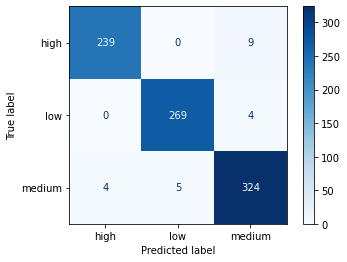

In [11]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [12]:
# Evaluate model using 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=5)

# Print average performance across all folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.01)


In [13]:
#Drop unneccessary columns and rows with NAN and infinity values
#This set has var_boxes 

df2 = df.drop(['ranch_sub', 'prod_yr', 'color', 'yield', 'color_code','variety_desc', 'ranch_no', 'var_cd', 'acres'], axis=1)
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()

#merge weather dataset so production/graft datasets
merged_df = pd.merge(df2, temps_df, on=['year', 'month', 'day'], how='inner')

yield_class = merged_df['yield_class']

#drop yield_class from dataset
merged_df = merged_df.drop(['yield_class'], axis = 1)


X, y = merged_df, yield_class

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
merged_df

Accuracy: 0.8255269320843092


,var_boxes,grafted,year_planted_grafted,ALLISON - SHEEGENE 20,ARD 35 - FIRE CRUNCH,ARD 36 - CHERRY CRUSH,ARD 39 - SUNNY POP,ARRA 15 - SWEETIES,ARRA 16,ARRA 27 - ARRA MYSTIC STAR,...,ranch_32,ranch_33,ranch_34,ranch_35,ranch_36,ranch_37,ranch_50,Daily_High,Daily _Low,Precipitation
0,3905,True,2009,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,94,68,0.0
1,3038,True,2017,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,94,68,0.0
2,3038,True,2018,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,94,68,0.0
3,6389,True,2006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,94,68,0.0
4,23119,True,2006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,94,68,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,23204,False,2012,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,74,39,0.0
4263,667,True,2017,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,74,39,0.0
4264,4155,False,2009,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,93,65,0.0
4265,4155,True,2017,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,93,65,0.0


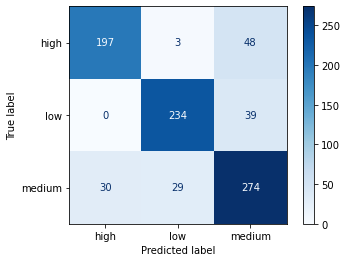

In [14]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [15]:
# Evaluate model using 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=5)

# Print average performance across all folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.02)


In [16]:
#Drop unneccessary columns and rows with NAN and infinity values
#This set does NOT have var_boxes or acres

df2 = df.drop(['ranch_sub', 'prod_yr', 'color', 'yield', 'color_code','variety_desc', 'ranch_no', 'var_cd', 'acres', 'var_boxes'], axis=1)
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()

#merge weather dataset so production/graft datasets
merged_df = pd.merge(df2, temps_df, on=['year', 'month', 'day'], how='inner')

yield_class = merged_df['yield_class']

#drop yield_class from dataset
merged_df = merged_df.drop(['yield_class'], axis = 1)


X, y = merged_df, yield_class

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
merged_df

Accuracy: 0.594847775175644


,grafted,year_planted_grafted,ALLISON - SHEEGENE 20,ARD 35 - FIRE CRUNCH,ARD 36 - CHERRY CRUSH,ARD 39 - SUNNY POP,ARRA 15 - SWEETIES,ARRA 16,ARRA 27 - ARRA MYSTIC STAR,ARRA 28 - ARRA PASSION PUNCH,...,ranch_32,ranch_33,ranch_34,ranch_35,ranch_36,ranch_37,ranch_50,Daily_High,Daily _Low,Precipitation
0,True,2009,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,94,68,0.0
1,True,2017,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,94,68,0.0
2,True,2018,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,94,68,0.0
3,True,2006,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,94,68,0.0
4,True,2006,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,94,68,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,False,2012,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,74,39,0.0
4263,True,2017,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,74,39,0.0
4264,False,2009,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,93,65,0.0
4265,True,2017,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,93,65,0.0


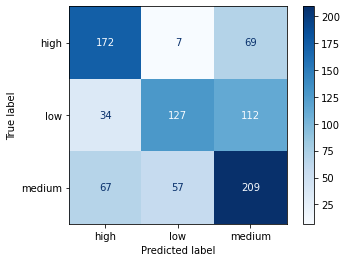

In [17]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [18]:
# Evaluate model using 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=5)

# Print average performance across all folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.45 (+/- 0.07)
